In [118]:
import os
import tarfile
from six.moves import urllib
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from pandas import DataFrame

ATTENDANCE_PATH = os.path.join("datasets", "attendance")

def percentage_to_float(x):
    if x=='':
        return 0
    else:
        return float(x.strip('%')) / 100.0

def load_attendance_data(attendance_path=ATTENDANCE_PATH):
    csv_path = os.path.join(attendance_path, "stud-stat-anonymous.csv")
    return pd.read_csv(csv_path, converters={'Samlet fravær':percentage_to_float, 'Fravær':percentage_to_float, 'Fravær.1':percentage_to_float, 'Fravær.2':percentage_to_float, 'Fravær.3':percentage_to_float})

In [119]:
attendance = load_attendance_data()
attendance.head()

,Unnamed: 0,Id,Samlet fravær,Klasse,Fag,Fravær,Fag.1,Fravær.1,Fag.2,Fravær.2,Fag.3,Fravær.3
0,0,214366,1.0,Web and Soft Electives,Big Data,1.0,NaN,0.0,NaN,0.0,NaN,0.0
1,1,680092,1.0,Web and Soft Electives,Angular,1.0,Web Security,1.0,NaN,0.0,NaN,0.0
2,2,906441,1.0,Web and Soft Electives,Angular,1.0,Web Security,1.0,NaN,0.0,NaN,0.0
3,3,432875,1.0,Web and Soft Electives,Angular,1.0,Web Security,1.0,NaN,0.0,NaN,0.0
4,4,146518,1.0,Web and Soft Electives,Angular,1.0,Web Security,1.0,NaN,0.0,NaN,0.0


In [120]:
attendance = attendance.drop(['Unnamed: 0'], axis=1)
attendance.head()

,Id,Samlet fravær,Klasse,Fag,Fravær,Fag.1,Fravær.1,Fag.2,Fravær.2,Fag.3,Fravær.3
0,214366,1.0,Web and Soft Electives,Big Data,1.0,NaN,0.0,NaN,0.0,NaN,0.0
1,680092,1.0,Web and Soft Electives,Angular,1.0,Web Security,1.0,NaN,0.0,NaN,0.0
2,906441,1.0,Web and Soft Electives,Angular,1.0,Web Security,1.0,NaN,0.0,NaN,0.0
3,432875,1.0,Web and Soft Electives,Angular,1.0,Web Security,1.0,NaN,0.0,NaN,0.0
4,146518,1.0,Web and Soft Electives,Angular,1.0,Web Security,1.0,NaN,0.0,NaN,0.0


In [121]:
transform_func = dict(
        Fag=attendance.filter(regex="^Fag").columns,
        Fravær=attendance.filter(regex="^Fravær").columns
)

transformed_attendance = pd.lreshape(attendance, transform_func)
transformed_attendance.head()

,Id,Klasse,Samlet fravær,Fag,Fravær
0,214366,Web and Soft Electives,1.0,Big Data,1.0
1,680092,Web and Soft Electives,1.0,Angular,1.0
2,906441,Web and Soft Electives,1.0,Angular,1.0
3,432875,Web and Soft Electives,1.0,Angular,1.0
4,146518,Web and Soft Electives,1.0,Angular,1.0


In [122]:
distinct_classes = list(set(transformed_attendance["Klasse"]))

In [123]:
distinct_subjects = list(set(transformed_attendance["Fag"]))

In [124]:
# Try to get the median for attendance
attendance_sorted = transformed_attendance.copy()
attendance_sorted.sort_values([ "Fag", "Fravær"], axis=0, ascending=True, inplace=True)
# attendance_sorted.head()

In [125]:
# attendance_sorted['MinForClass'] = attendance_sorted.groupby(['Fag'])['Fravær'].mean()
mean_attendance_per_subject = attendance_sorted.groupby(['Fag'])['Fravær'].mean()
mean_attendance_per_subject

Fag
Angular                        0.574304
Big Data                       0.484420
DLS                            0.562424
Data Science                   0.204832
Databases                      0.193182
IT Governance 2                0.000000
Interface Design               0.394638
Intro til IT Sikkerhed         0.486950
Net. and Com. security         0.543750
Quantum Computing              0.166667
Reverse Eng. Malware           0.318966
Security Engineering           0.419021
Security for mobile devices    0.462569
Software Design Patterns       0.310786
System Integration             0.388889
System Security                0.424075
Test                           0.283145
Web Development                0.130266
Web Security                   0.349587
Name: Fravær, dtype: float64

In [126]:
df = DataFrame(mean_attendance_per_subject)
df.count()

Fravær    19
dtype: int64

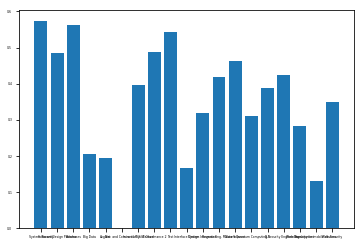

In [127]:
x = np.arange(19)
fig, ax = plt.subplots()
ax.tick_params(labelsize=3)
plt.bar(x, df['Fravær'])
plt.xticks(x, distinct_subjects)
plt.show()


In [128]:
#transformed_attendance = transformed_attendance.drop(['Fag'], axis=1)
#transformed_attendance = transformed_attendance.drop(['Klasse'], axis=1)

#transformed_attendance = transformed_attendance.sort_values("Id")

#transformed_attendance.head()

In [129]:
continuous_features = ['Samlet fravær', 'Fravær']

transformed_attendance[continuous_features].describe()

,Samlet fravær,Fravær
count,645.000000,645.000000
mean,0.372572,0.338131
std,0.306235,0.356557
min,0.000000,0.000000
25%,0.106000,0.000000
50%,0.287000,0.222200
75%,0.530000,0.575800
max,1.000000,1.000000


In [130]:
total_abscence = transformed_attendance[['Samlet fravær', 'Fravær']]
total_abscence.head()

,Samlet fravær,Fravær
0,1.0,1.0
1,1.0,1.0
2,1.0,1.0
3,1.0,1.0
4,1.0,1.0


In [131]:
# For each k value, we will initialise k-means and use the inertia attribute to identify the sum of squared distances of samples to the nearest cluster centre.

Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(total_abscence)
    Sum_of_squared_distances.append(km.inertia_)


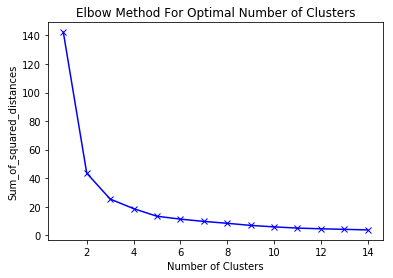

In [132]:
# Below is a plot of sum of squared distances for k in the range specified above. If the plot looks like an arm, then the elbow on the arm is optimal k.
# In the plot below, the elbow is at k=3 indicating the optimal k for this dataset is 3


plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.show()

[[0.42617617 0.45766269]
 [0.16421194 0.05841731]
 [0.88073504 0.94184701]]


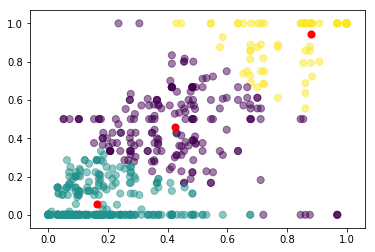

In [137]:
#df = DataFrame(transformed_attendance,columns=['Samlet fravær','Fravær', 'Id'])
kmeans = KMeans(n_clusters=3).fit(total_abscence)
centroids = kmeans.cluster_centers_
print(centroids)

plt.scatter( total_abscence['Samlet fravær'],total_abscence['Fravær'], c= kmeans.labels_, s=50, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1],s=50, c='red')
